In [ ]:
#Test different configurations of the regressions

In [1]:
from category_encoders import *
import pandas as pd
import numpy as np
from sklearn import linear_model
# Import the preprocessing module
from sklearn.preprocessing import StandardScaler
from statsmodels.compat import lzip

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm

In [2]:
import os
from datetime import date    
today = date.today()
## Get output folder
dr = str(today.year)+str(today.month).zfill(2)
#os.chdir('/Users/sara.runkel/Documents/13000Cities/')
output_dir = '/Users/sara.runkel/Documents/13000Cities/Outputs/' + dr +'/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print('Made monthly output directory')
if not os.path.exists(output_dir+today.isoformat()):
    os.makedirs(output_dir+today.isoformat())
    print('Made daily output directory')
output_dir = '/Users/sara.runkel/Documents/13000Cities/Outputs/' + dr +'/' + today.isoformat() +'/'

In [3]:
# base diagnostic code
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

In [12]:
def calculate_stats(dataframe,predicted, actual):
    dataframe['Predicted']=np.exp(predicted)
    dataframe['Actual']= np.exp(actual)
    dataframe['pc_dif']=100*(dataframe.Actual-dataframe.Predicted)/dataframe.Actual
    dataframe['abs_dif']= dataframe['pc_dif'].abs()
    dataframe['Residuals']= dataframe.Actual-dataframe.Predicted

In [5]:
df = pd.read_csv('us_asthmaprediction.csv')

In [ ]:
##Test inclusion of different variables
##Possible variables: Population, GDP, Region, State

In [ ]:
##Different encoder methods to test (ADD one hot encoding)

encoders = [GLMMEncoder(cols=['Region']).fit(X,y),QuantileEncoder(cols=['Region'],quantile=0.25).fit(X, y), OneHotEncoder(cols=['Region']).fit(X,y)]

In [13]:
def diagnostics(enc, y, X):
    numeric_dataset = enc.transform(X)
    X2 = sm.add_constant(numeric_dataset)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    cls = LinearRegDiagnostic(est2)
    vif, fig, ax = cls()
    print(vif)
    print(est2.summary())
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(numeric_dataset, y)
    coef = regr.coef_
    #coef = np.polyfit(x, y, z, 1)
    inter = regr.intercept_
    actual = []
    predicted = []
    for ind in range(len(numeric_dataset)):
        actual.append(y.iloc[ind])
        predicted.append(sum([coef[i]*numeric_dataset.iloc[ind][i] for i in range(len(coef))])+inter)
        
    ##predicted is predicted NO2/capita
    return calculate_stats(df,predicted,actual)

In [9]:
df.columns

Index(['Unnamed: 0', 'Memberships', 'continent', 'Year', 'City', 'Country',
       'Latitude', 'Longitude', 'Population', 'NO2', 'Pw_NO2', 'PAF_NO2',
       'Cases_NO2', 'Rates_NO2', 'Pop_ped', 'city_area', 'NAME_LIST', 'Slope',
       'Base_GDP', 'GDP', 'Base_NO2', 'Base_Population', 'NO2T', 'BaseT',
       'LogGDP', 'State', 'Region', 'Predicted', 'Actual', 'pc_dif', 'abs_dif',
       'Residuals', 'PerCapita', 'ConcPercChange', 'ConcChange_Score',
       'slope_Score', 'resid_Score', 'Total_Score', 'GDPBins', 'PopChange',
       'PopChangeBins', 'Base_PerCapita', 'Base_Pop_ped', 'location_name_x',
       'asthma_2010', 'location_name_y', 'asthma_2019', 'ActualAF',
       'PredictedAF', 'BaseAF', 'Actual_Cases', 'Predicted_Cases',
       'Base_Cases', 'Cases_Residual', 'Rates_Residual'],
      dtype='object')

Runnng diagnostics for GLMM


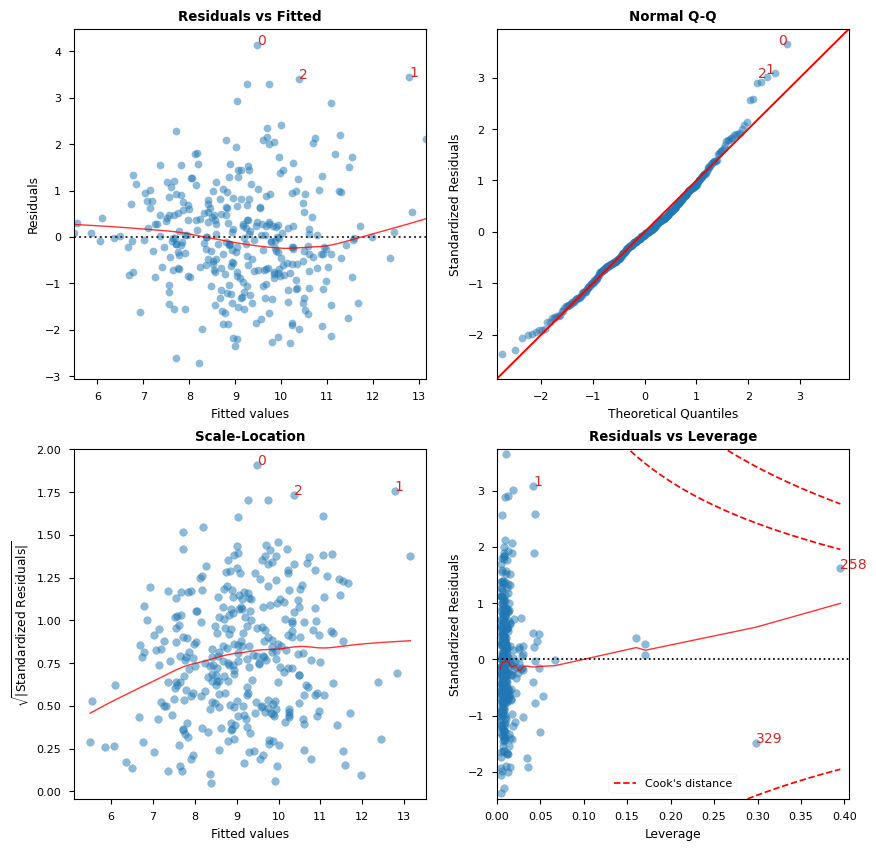

     Features  VIF Factor
3      Region        1.13
2    Base_GDP        1.24
1    Base_NO2        1.35
4  Population        1.42
0       const       42.23
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     110.7
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.95e-59
Time:                        09:42:43   Log-Likelihood:                -509.75
No. Observations:                 330   AIC:                             1029.
Df Residuals:                     325   BIC:                             1048.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

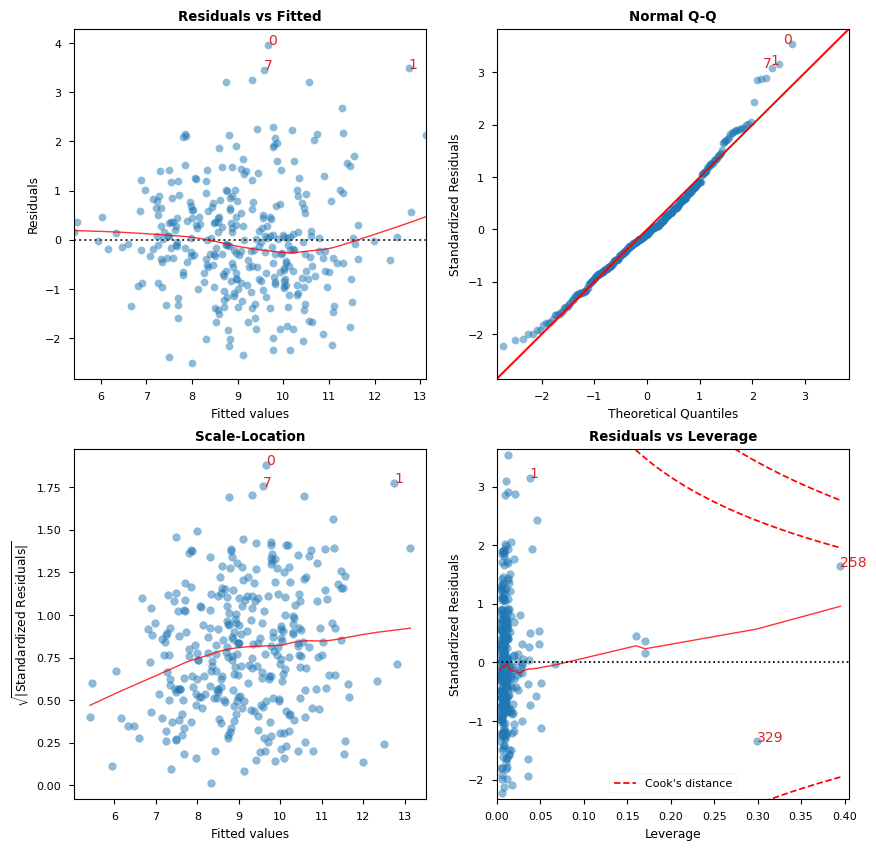

     Features  VIF Factor
3      Region        1.09
2    Base_GDP        1.24
1    Base_NO2        1.30
4  Population        1.42
0       const      111.48
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     116.5
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.61e-61
Time:                        09:42:44   Log-Likelihood:                -504.85
No. Observations:                 330   AIC:                             1020.
Df Residuals:                     325   BIC:                             1039.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

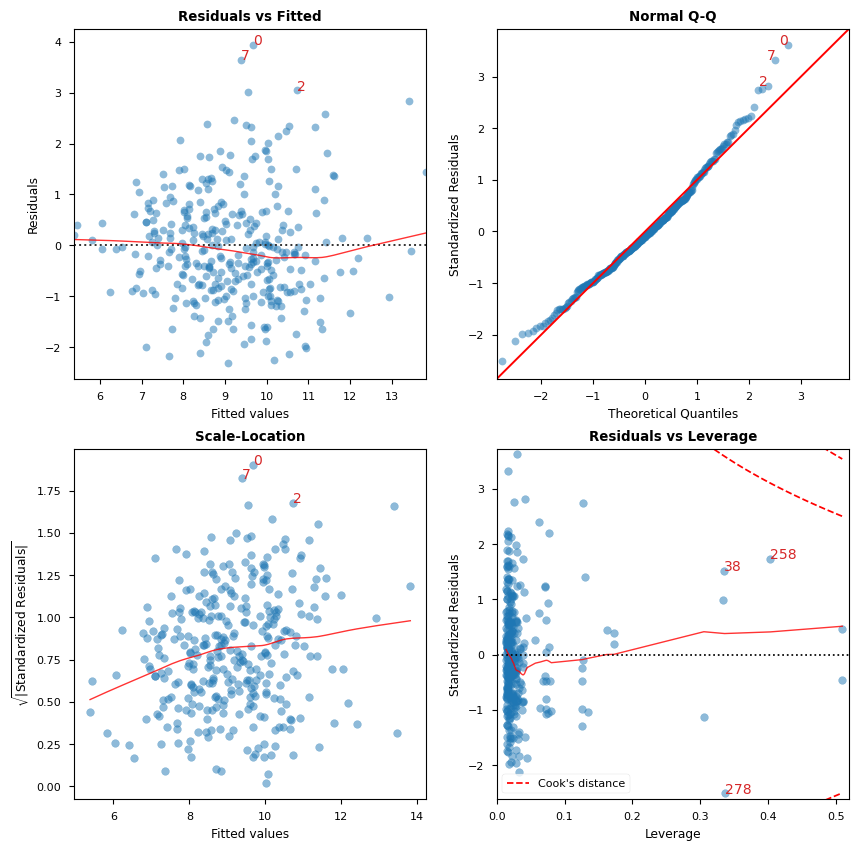

      Features    VIF Factor
0        const  0.000000e+00
2     Base_GDP  1.320000e+00
12  Population  1.450000e+00
1     Base_NO2  1.520000e+00
5     Region_3  9.007199e+15
8     Region_6  9.007199e+15
3     Region_1           inf
4     Region_2           inf
6     Region_4           inf
7     Region_5           inf
9     Region_7           inf
10    Region_8           inf
11    Region_9           inf
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     45.80
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           5.16e-59
Time:                        09:42:45   Log-Likelihood:                -494.98
No. Observations:                 330   AIC:                             1014.
Df Residuals:                     318   B

/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [18]:
##Test non-transformed variables
y = df['NO2']
X = df[['Base_NO2','Base_GDP','Region','Population']]
encoders = {'GLMM':GLMMEncoder(cols=['Region']).fit(X,y),'Quantile':QuantileEncoder(cols=['Region'],quantile=0.25).fit(X, y), 'OneHot':OneHotEncoder(cols=['Region']).fit(X,y)}

for i in encoders:
    print('Runnng diagnostics for '+i)
    diagnostics(encoders[i],y,X)

Runnng diagnostics for GLMM


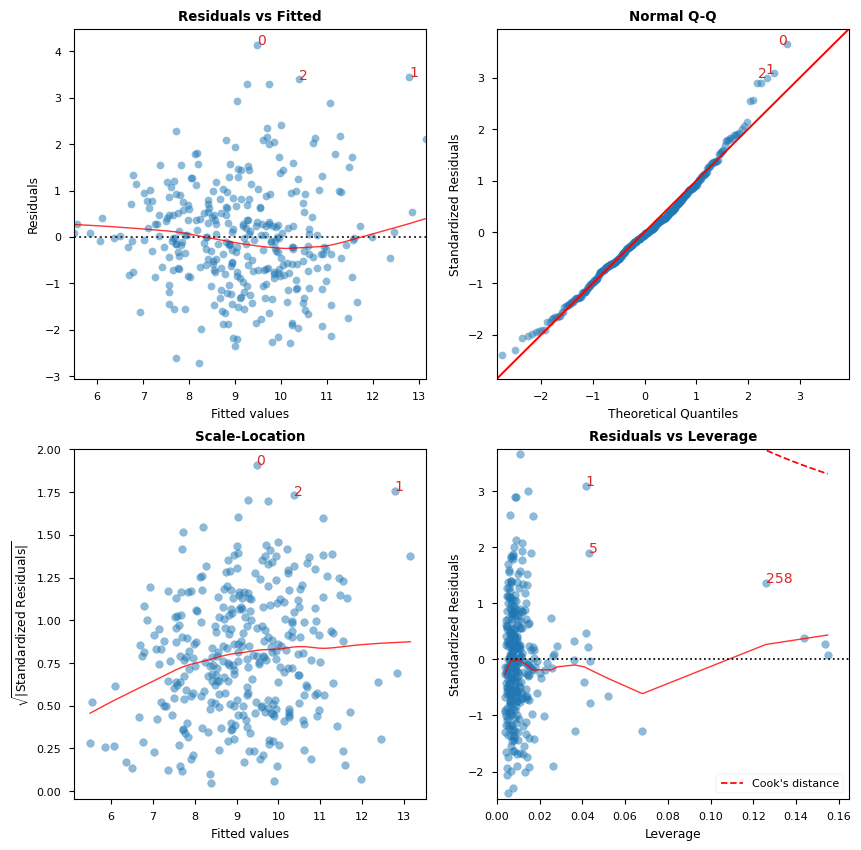

   Features  VIF Factor
2  Base_GDP        1.07
3    Region        1.11
1  Base_NO2        1.17
0     const       37.32
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     148.1
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.47e-60
Time:                        01:47:24   Log-Likelihood:                -509.75
No. Observations:                 330   AIC:                             1027.
Df Residuals:                     326   BIC:                             1043.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

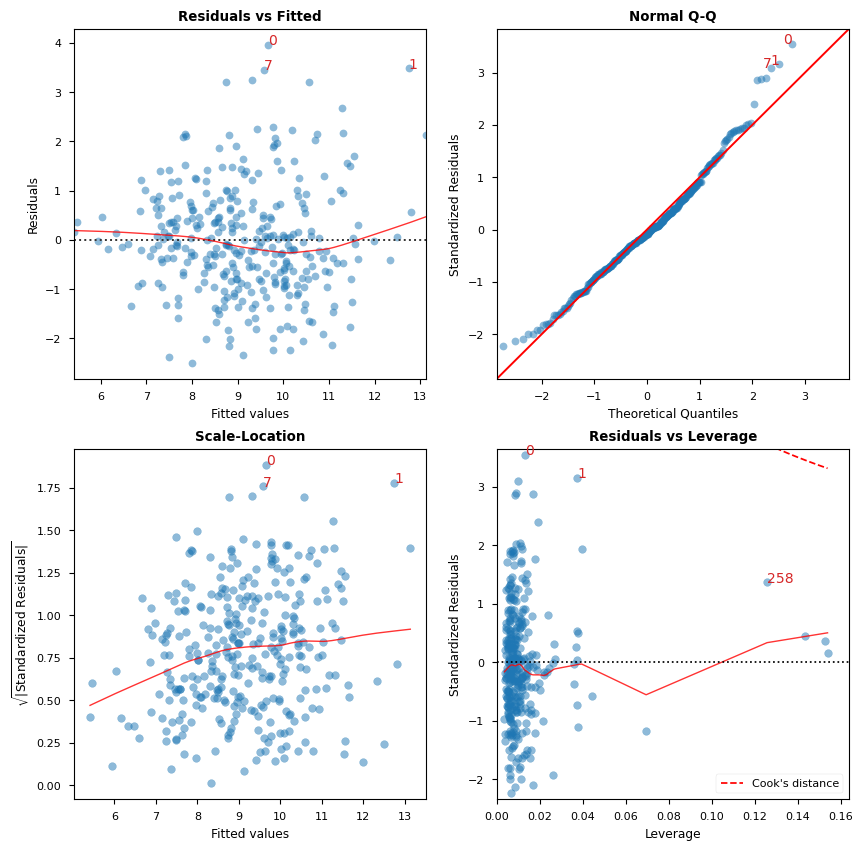

   Features  VIF Factor
2  Base_GDP        1.06
3    Region        1.07
1  Base_NO2        1.13
0     const      110.58
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     155.8
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.18e-62
Time:                        01:47:25   Log-Likelihood:                -504.85
No. Observations:                 330   AIC:                             1018.
Df Residuals:                     326   BIC:                             1033.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

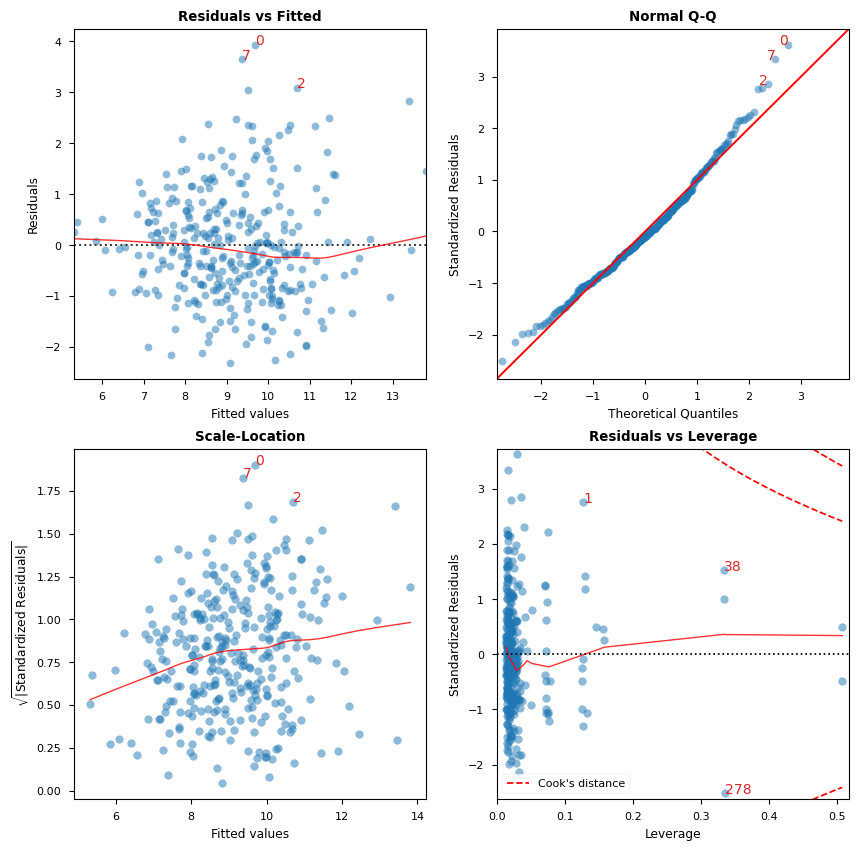

    Features    VIF Factor
0      const  0.000000e+00
2   Base_GDP  1.140000e+00
1   Base_NO2  1.300000e+00
9   Region_7  9.007199e+15
3   Region_1           inf
4   Region_2           inf
5   Region_3           inf
6   Region_4           inf
7   Region_5           inf
8   Region_6           inf
10  Region_8           inf
11  Region_9           inf
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     50.48
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           7.81e-60
Time:                        01:47:26   Log-Likelihood:                -495.09
No. Observations:                 330   AIC:                             1012.
Df Residuals:                     319   BIC:                             1054.
Df Model:        

/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [15]:
##Test non-transformed variables
y = df['NO2']
X = df[['Base_NO2','Base_GDP','Region']]
encoders = {'GLMM':GLMMEncoder(cols=['Region']).fit(X,y),'Quantile':QuantileEncoder(cols=['Region'],quantile=0.25).fit(X, y), 'OneHot':OneHotEncoder(cols=['Region']).fit(X,y)}

for i in encoders:
    print('Runnng diagnostics for '+i)
    diagnostics(encoders[i],y,X)

Runnng diagnostics for GLMM


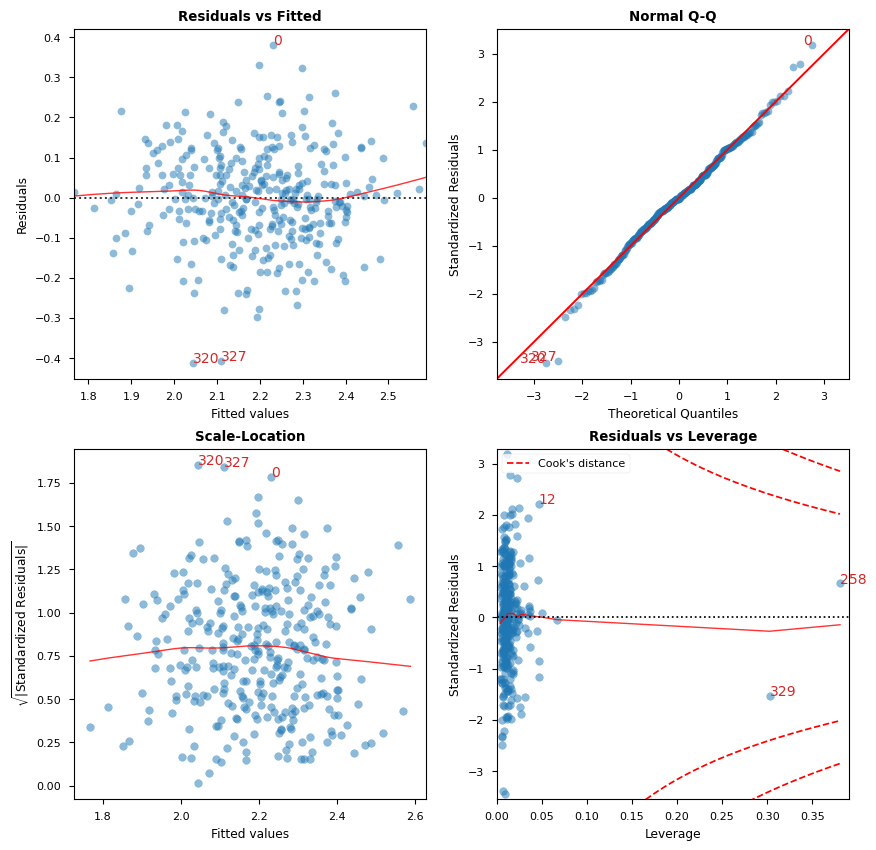

     Features  VIF Factor
3      Region        1.19
4  Population        1.27
2      LogGDP        1.29
1       BaseT        1.44
0       const      258.56
                            OLS Regression Results                            
Dep. Variable:                   NO2T   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     122.7
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.07e-63
Time:                        09:48:10   Log-Likelihood:                 233.03
No. Observations:                 330   AIC:                            -456.1
Df Residuals:                     325   BIC:                            -437.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

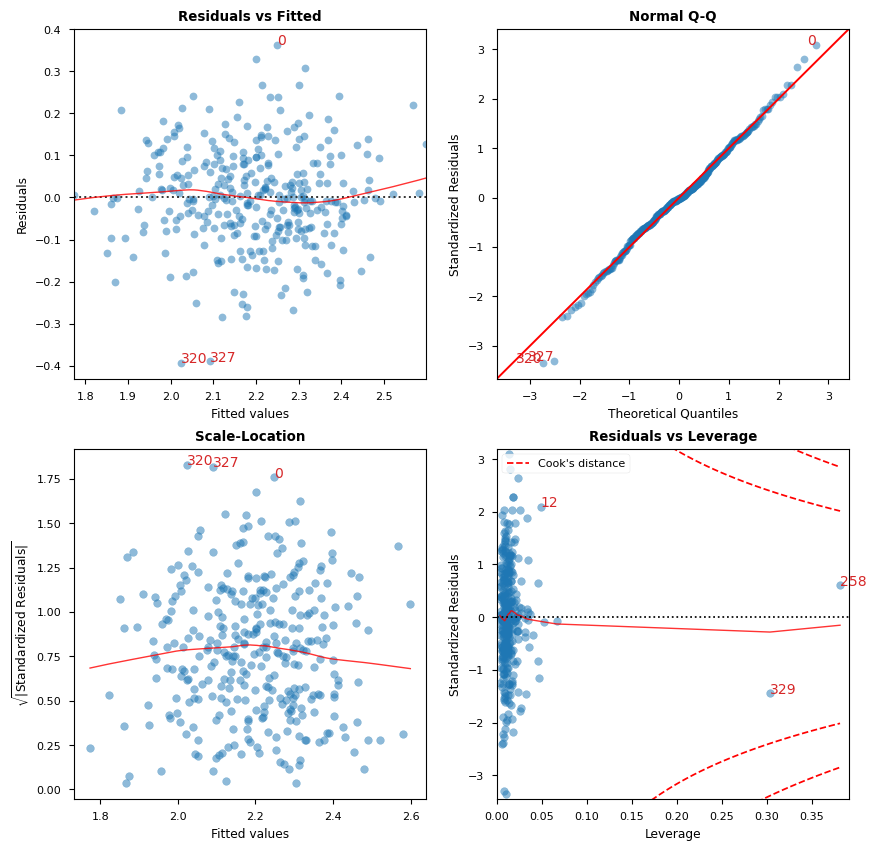

     Features  VIF Factor
3      Region        1.12
2      LogGDP        1.26
4  Population        1.27
1       BaseT        1.36
0       const      744.90
                            OLS Regression Results                            
Dep. Variable:                   NO2T   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     131.1
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.67e-66
Time:                        09:48:11   Log-Likelihood:                 239.62
No. Observations:                 330   AIC:                            -469.2
Df Residuals:                     325   BIC:                            -450.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

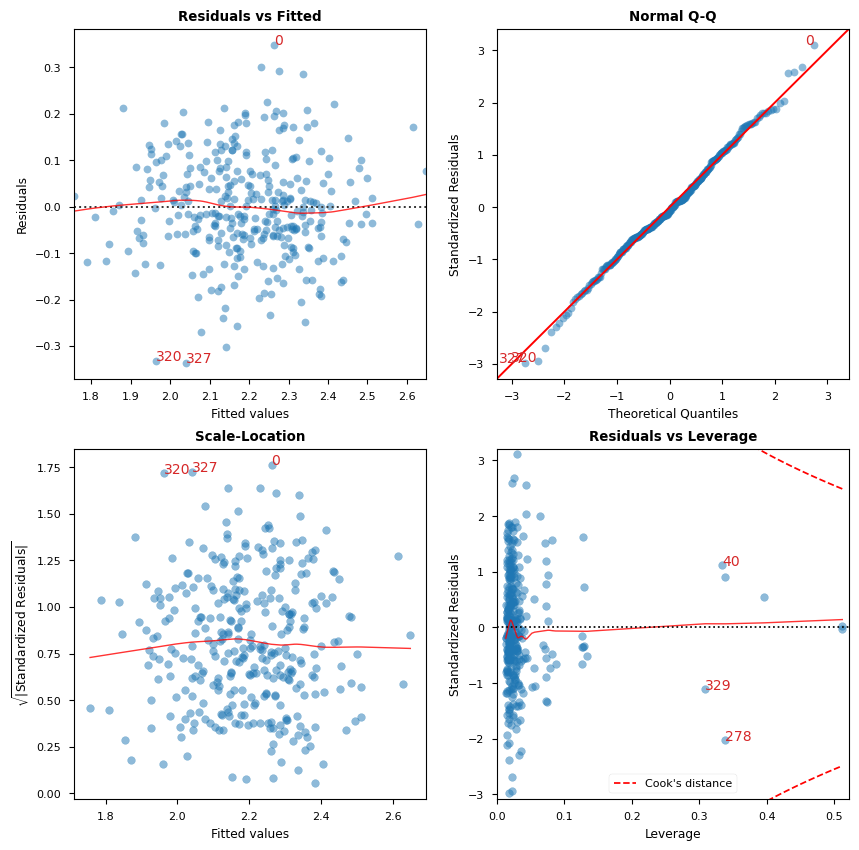

/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


      Features  VIF Factor
0        const        0.00
12  Population        1.28
2       LogGDP        1.41
1        BaseT        1.64
3     Region_1         inf
4     Region_2         inf
5     Region_3         inf
6     Region_4         inf
7     Region_5         inf
8     Region_6         inf
9     Region_7         inf
10    Region_8         inf
11    Region_9         inf
                            OLS Regression Results                            
Dep. Variable:                   NO2T   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     53.84
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           5.85e-66
Time:                        09:48:11   Log-Likelihood:                 254.66
No. Observations:                 330   AIC:                            -485.3
Df Residuals:                     318   BIC:                         

In [21]:
y= df['NO2T']
X = df[['BaseT','LogGDP','Region','Population']]
encoders = {'GLMM':GLMMEncoder(cols=['Region']).fit(X,y),'Quantile':QuantileEncoder(cols=['Region'],quantile=0.25).fit(X, y), 'OneHot':OneHotEncoder(cols=['Region']).fit(X,y)}

for i in encoders:
    print('Runnng diagnostics for '+i)
    diagnostics(encoders[i],y,X)

In [20]:
df.columns

Index(['Unnamed: 0', 'Memberships', 'continent', 'Year', 'City', 'Country',
       'Latitude', 'Longitude', 'Population', 'NO2', 'Pw_NO2', 'PAF_NO2',
       'Cases_NO2', 'Rates_NO2', 'Pop_ped', 'city_area', 'NAME_LIST', 'Slope',
       'Base_GDP', 'GDP', 'Base_NO2', 'Base_Population', 'NO2T', 'BaseT',
       'LogGDP', 'State', 'Region', 'Predicted', 'Actual', 'pc_dif', 'abs_dif',
       'Residuals', 'PerCapita', 'ConcPercChange', 'ConcChange_Score',
       'slope_Score', 'resid_Score', 'Total_Score', 'GDPBins', 'PopChange',
       'PopChangeBins', 'Base_PerCapita', 'Base_Pop_ped', 'location_name_x',
       'asthma_2010', 'location_name_y', 'asthma_2019', 'ActualAF',
       'PredictedAF', 'BaseAF', 'Actual_Cases', 'Predicted_Cases',
       'Base_Cases', 'Cases_Residual', 'Rates_Residual'],
      dtype='object')

Runnng diagnostics for GLMM


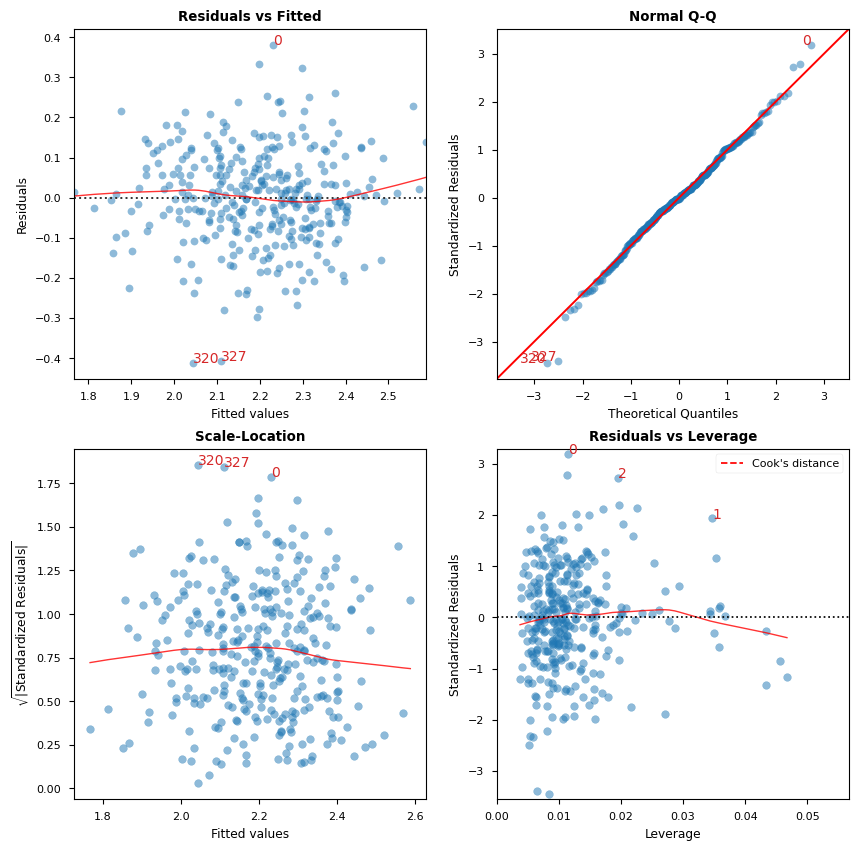

  Features  VIF Factor
3   Region        1.18
2   LogGDP        1.22
1    BaseT        1.31
0    const      209.69
                            OLS Regression Results                            
Dep. Variable:                   NO2T   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     164.2
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           7.67e-65
Time:                        01:48:47   Log-Likelihood:                 233.03
No. Observations:                 330   AIC:                            -458.1
Df Residuals:                     326   BIC:                            -442.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

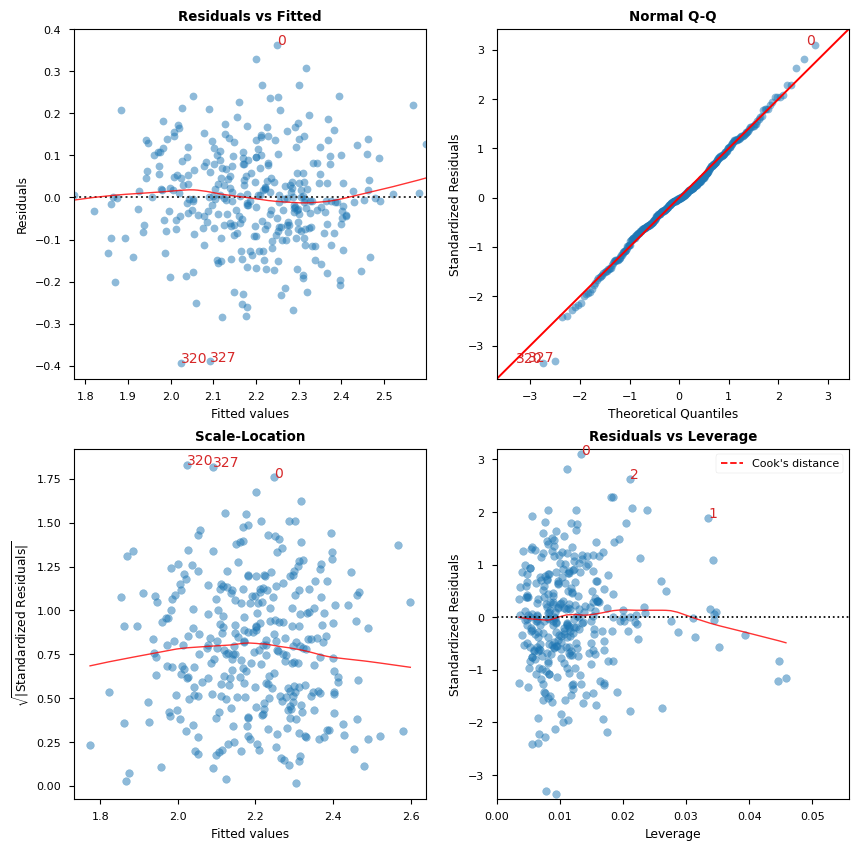

  Features  VIF Factor
3   Region        1.12
2   LogGDP        1.18
1    BaseT        1.24
0    const      719.76
                            OLS Regression Results                            
Dep. Variable:                   NO2T   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     175.3
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.16e-67
Time:                        01:48:47   Log-Likelihood:                 239.62
No. Observations:                 330   AIC:                            -471.2
Df Residuals:                     326   BIC:                            -456.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

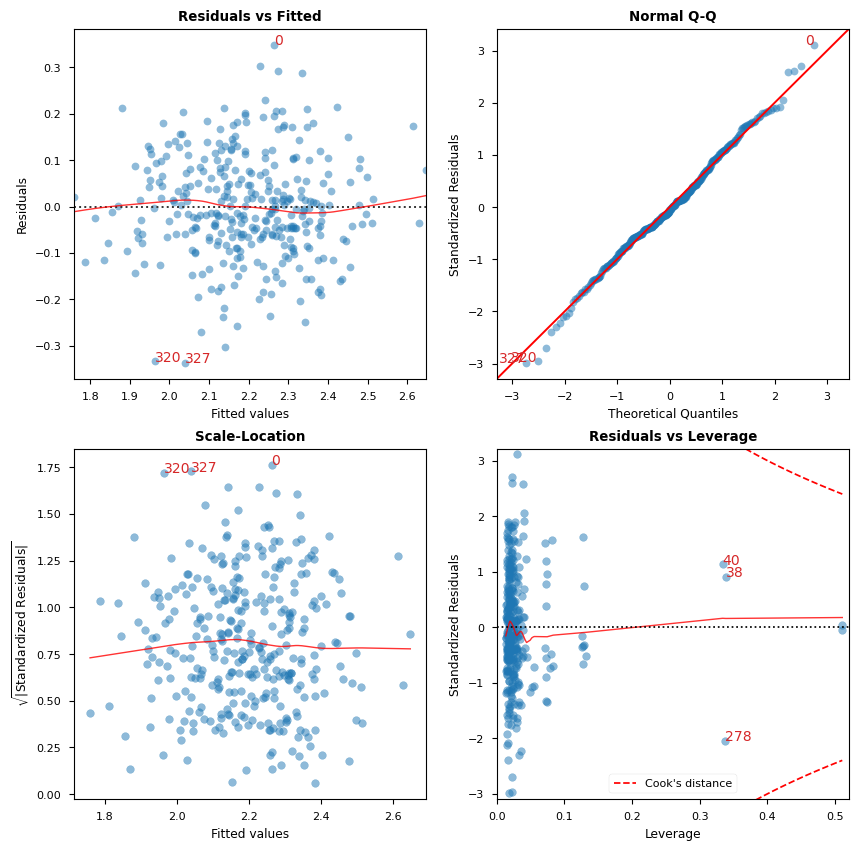

    Features  VIF Factor
0      const        0.00
2     LogGDP        1.33
1      BaseT        1.49
3   Region_1         inf
4   Region_2         inf
5   Region_3         inf
6   Region_4         inf
7   Region_5         inf
8   Region_6         inf
9   Region_7         inf
10  Region_8         inf
11  Region_9         inf
                            OLS Regression Results                            
Dep. Variable:                   NO2T   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     59.36
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           8.01e-67
Time:                        01:48:48   Log-Likelihood:                 254.58
No. Observations:                 330   AIC:                            -487.2
Df Residuals:                     319   BIC:                            -445.4
Df Model:                          10      

/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/sara.runkel/opt/anaconda3/envs/basemap-plotting/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [16]:
y= df['NO2T']
X = df[['BaseT','LogGDP','Region']]
encoders = {'GLMM':GLMMEncoder(cols=['Region']).fit(X,y),'Quantile':QuantileEncoder(cols=['Region'],quantile=0.25).fit(X, y), 'OneHot':OneHotEncoder(cols=['Region']).fit(X,y)}

for i in encoders:
    print('Runnng diagnostics for '+i)
    diagnostics(encoders[i],y,X)

In [17]:
from scipy.stats.mstats import zscore
zx =zscore(numeric_dataset)
zy = zscore(y)
#zx2 = sm.add_constant(zx)
model = sm.OLS(zy,zx)
results = model.fit()
results.params

NameError: name 'numeric_dataset' is not defined